**API Import**

In [2]:
import requests
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)
    

def carparkApiCall(year, month, day, hour, minute, second, error_count):
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    try:
        open(fDir, 'r')
    except:
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        # If file doesn't exist, api call
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        # print(site)
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        try:
            timestamp = data["items"][0]["timestamp"]
            data = data["items"][0]["carpark_data"]
        except:
            print(data)
            print(year,'/', month, '/', day, 'T', hour, minute, second)
            error_count+=1
            print("error count:", error_count)
            if error_count<=5:
                return carparkApiCall(year, month, day, hour, minute, second, error_count)
            else:
                "Api call failed more than 5 times :("
        # print(timestamp)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
    df = pd.read_json(fDir)
    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    # Transform data
    df = df.drop(["carpark_info"], axis=1)
    df['update_datetime'] = df['update_datetime'].apply(toIso)
    df["lots_available"] = df["lots_available"].astype(int)
    df["total_lots"] = df["total_lots"].astype(int)
    return df

 **Question 1.1**
 LTA Datamall API documentation
 Type of lots:
- C (for Cars)
- H (for Heavy Vehicles)
- Y (for Motorcycles)

![image.png](attachment:image.png)
https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf

**Question 1.2**

In [3]:
year = "2022"
month = "1"
day = "17"
hour = "4"
minute = "30"
second = "0"
curr_df = carparkApiCall(year, month, day, hour, minute, second,0)
curr_df.loc[0,'update_datetime']
# print(curr_df.head())

Timestamp('2022-01-17 04:20:12')

1 second later

In [4]:
second = str(int(second) + 1)
next_df = carparkApiCall(year, month, day, hour, minute, second,0)
next_df.loc[0,'update_datetime']

Timestamp('2022-01-17 04:20:12')

Iterate through intervals of 5 mins for 5 random hours and average the time difference of update_datetime.

In [5]:
from datetime import timedelta
from random import randint
from random import seed

total_time_interval = timedelta()
seed(10)
for _ in range (5):
    # samples for 5 different hours
    hour = str(randint(0,23))
    minute = "0"
    prev_df = carparkApiCall(year, month, day, hour, minute, second, 0)   
    for i in range(5,59,5):
        # Iterate through interval of 5 mins
        next_min = str(int(minute) + i)
        next_df = carparkApiCall(year, month, day, hour, next_min, second, 0)
        # When different update_datetime is found
        if(prev_df.loc[0,'update_datetime'] != next_df.loc[0,'update_datetime']):
            prev_datetime = prev_df.loc[0,'update_datetime']
            next_datetime = next_df.loc[0,'update_datetime']
            total_time_interval += next_datetime - prev_datetime
            break
# Average time interval
print(total_time_interval/5)

0 days 00:30:30.200000


**ANSWER**<br>
Approximate frequency at which the data values are updated is 30 mins 30 seconds

**Question 1.3**


**Part I**<br>
How many carparks are included in the data.gov.sg car park database?
There are 1966 carparks as of 1st October 2022

In [6]:
year = 2022
month = 10
day = 14
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
# generate data
df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
carpark_count = pd.DataFrame(df).drop_duplicates(subset='carpark_number', keep="last")["carpark_number"].count()
print(f'There are {carpark_count} carparks as of {day}/{month}/{year}')

There are 1968 carparks as of 14/10/2022


**Part II**<br>
Does this number vary based on the time? You should notice that it does vary with time.

In [7]:
year = 2022
month = 2
day = 2
hour = 0
minute = 1
second = 0

while month<=10:
    dt = datetime(year, month, day, hour, minute, second)
    # generate data
    
    df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    carpark_count = pd.DataFrame(df).drop_duplicates(subset='carpark_number', keep="last")["carpark_number"].count()
    print(f'There are {carpark_count} carparks as of {day}/{month}/{year}')
    month += 1

There are 1958 carparks as of 2/2/2022
There are 1959 carparks as of 2/3/2022
There are 1960 carparks as of 2/4/2022
There are 1962 carparks as of 2/5/2022
There are 1962 carparks as of 2/6/2022
There are 1962 carparks as of 2/7/2022
There are 1962 carparks as of 2/8/2022
There are 1965 carparks as of 2/9/2022
There are 1966 carparks as of 2/10/2022


There are more carparks added every month.

**Part III**<br>
A
carpark may have malfunctioning sensors and nor report its data. Identify one of these
carparks with anomalous sensors and a time period where that carpark’s sensors were
malfunctioning.

In [8]:
year = 2022
month = 9
day = 1
hour = 0
minute = 1
second = 0

malfunctioning = set()
dt = datetime(year, month, day, hour, minute, second)
# generate data
df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
df.sort_values(by=['total_lots'], inplace=True)
bad_carparks = df.loc[(df['lots_available'].astype(int) > df['total_lots'].astype(int))]
print(bad_carparks)
print(f'These carparks have malfunctioning sensors at {day}/{month}/{year} {str(hour).zfill(2)}:{str(minute).zfill(2)} :',list(bad_carparks["carpark_number"]))

    carpark_number     update_datetime  total_lots lot_type  lots_available
648          P40L1 2016-02-15 21:52:35           2        C               6
549          Y49HV 2016-02-15 21:52:35           3        C              28
649          P40L2 2016-02-15 21:52:35           3        C               6
599          MR567 2016-02-15 21:52:35          38        C              94
926           SK24 2016-02-19 11:19:28         181        Y             200
927           SK24 2016-02-19 11:19:29         181        H             200
These carparks have malfunctioning sensors at 1/9/2022 00:01 : ['P40L1', 'Y49HV', 'P40L2', 'MR567', 'SK24', 'SK24']


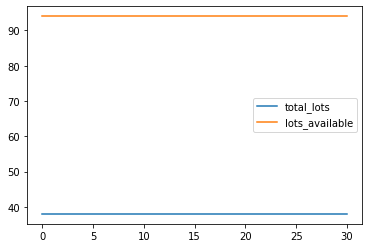

In [9]:
#looking at MR567 
# start date 1 Jul 2022 0000

import matplotlib.pyplot as plt

year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*30
lots_available = []
total_lots = []
# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    specific_data = df.loc[df["carpark_number"] == "MR567"].head(1)
    lots_available.append(specific_data["lots_available"].iloc[0])
    total_lots.append(specific_data["total_lots"].iloc[0])
plt.plot([x/24 for x in range(len(total_lots))], total_lots, label = "total_lots")
plt.plot([x/24 for x in range(len(lots_available))], lots_available, label = "lots_available")
plt.legend()
plt.show()
    


**Question 1.4**<br>
Generate hourly readings from the raw data. Select a one month interval and plot the
hourly data (time-series) for that interval (aggregate results instead of plotting for each
location individually). Identify any patterns in the visualization. Note: You will have to
decide what to do if there are no carpark readings for a certain hour, for example, should
you impute the missing data or ignore it.

In [10]:
# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"].sum()/len(df.index)

In [11]:
# start date 1 Jul 2022 0000
year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*30
timeseries_data = {
    'dt':[],
    'avail': []
}
total_lots = []
lots_available = []
error_count = 0
# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    lots_available.append(df["lots_available"].sum())
    total_lots.append(df["total_lots"].sum())
    timeseries_data['avail'].append(avrAvail(df))
    timeseries_data['dt'].append(df.loc[0,'update_datetime'])

    

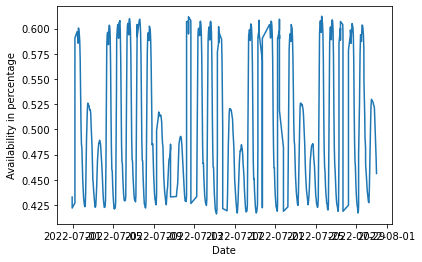

In [12]:
plt.plot(timeseries_data['dt'], timeseries_data["avail"])
plt.xlabel("Date")
plt.ylabel("Availability in percentage")
plt.show()

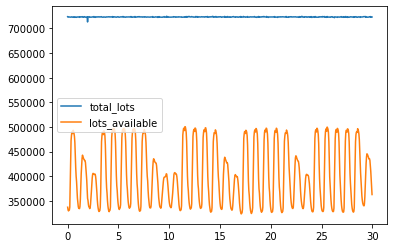

In [13]:
plt.plot([x/24 for x in range(len(total_lots))], total_lots, label = "total_lots")
plt.plot([x/24 for x in range(len(lots_available))], lots_available, label = "lots_available")
plt.legend()
plt.show()

In [14]:
import numpy as np
def correlation(arr1,arr2):
    ret = np.corrcoef(arr1,arr2)
    return ret[0][1]

In [15]:
# start date 1 Jul 2022 0000
year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0
fgfgfg
dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*30
total_lots = []
lots_available = []
error_count = 0
d = {}
# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    for index, row in df.iterrows():
        if row["carpark_number"] in d:
            d[row["carpark_number"]].append((row["lots_available"],row["total_lots"]))
        else:
            d[row["carpark_number"]] = [(row["lots_available"],row["total_lots"])]


In [16]:
def get_top_correlated(carpark_number,d,top):
    ls = []
    for key in d:
        if key != carpark_number:
            ls.append((correlation(d[key],d[carpark_number]),key))
    ls.sort()
    return ls[:top]

get_top_correlated("HLM",d,5)

c:\Users\Ethan Wong\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\Ethan Wong\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[(0.9999999999999998, 'BJ65'),
 (0.9999999999999998, 'BL19'),
 (0.9999999999999998, 'C7'),
 (0.9999999999999998, 'CR30'),
 (0.9999999999999998, 'HE12')]

In [ ]:
das